In [1]:
import os
HOME = os.getcwd()
print(HOME)

/root


In [2]:
if not os.path.exists("TrackNetV3"):
    !git clone https://github.com/lu-joseph/TrackNetV3
%cd {HOME}/TrackNetV3
if not os.path.exists("ckpts"):
    !wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1CfzE87a0f6LhBp0kniSl1-89zaLCZ8cA&export=download&authuser=0&confirm=t&uuid=fd5c99d1-dc6a-4011-948b-1d03be7d6628&at=AN_67v1rreyiyg-hMrVlkh9Np5is%3A1729497024731' -O TrackNetV3_ckpts.zip
    !unzip TrackNetV3_ckpts.zip
%cd {HOME}

/root/TrackNetV3
/root


In [2]:
%cd {HOME}/TrackNetV3
!pip install -r requirements.txt
%cd {HOME}

/root/TrackNetV3
/root


## Predict Video

In [3]:
%cd {HOME}/TrackNetV3
from predict import predict_video
video_file = "../videos/rally2.mp4"
tracknet_file = "ckpts/TrackNet_best.pt"
inpaintnet_file = "ckpts/InpaintNet_best.pt"

predict_video(
    video_file=video_file,
    tracknet_file=tracknet_file,
    inpaintnet_file=inpaintnet_file,
    batch_size=6)


/root/TrackNetV3


100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 83.58it/s]

Done.


## Splitting video into shots

In [2]:
%cd {HOME}
import supervision as sv
from courtiq_utils import split_into_shots

video_file = "videos/rally2.mp4"
split_into_shots(video_file)


/root
WARNING ⚠️ Python>=3.10 is required, but Python==3.8.10 is currently installed 


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


video name: rally2
done shot 8 at ./output/rally2/shot8.mp4
done


## Tracking players
Tracking only nearside player

### Skeleton joint ids:
0: Nose 1: Left Eye 2: Right Eye 3: Left Ear 4: Right Ear 5: Left Shoulder 6: Right Shoulder 7: Left Elbow 8: Right Elbow 9: Left Wrist 10: Right Wrist 11: Left Hip 12: Right Hip 13: Left Knee 14: Right Knee 15: Left Ankle 16: Right Ankle

In [ ]:
%cd {HOME}
import supervision as sv

# def callback(frame, _):
#     path = get_court_path(frame, 'near-side')
#     pose_results = get_pose_results_for_path(frame, path)
#     if not pose_results: return frame
#     img = pose_results.plot(boxes=False)
#     return img

# sv.process_video(source_path='./rally.mp4', target_path='./output/rally_annotated.mp4', callback=callback)

In [16]:
import courtiq_utils as ut
from importlib import reload
reload(ut)

<module 'courtiq_utils' from '/root/courtiq_utils.py'>

## Annotating clip

In [22]:
%cd {HOME}
import supervision as sv
from courtiq_utils import get_pose_results_on_court,pose_model,calculate_speed
import time
import cv2
from collections import defaultdict,deque

input = "./videos/rally2.mp4"
output = "./output/videos/rally2/annotated.mp4"
tracker = sv.ByteTrack()
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
cap = cv2.VideoCapture(input)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()
frame_rate = 30
speed_threshold = 0
# speed_diff_threshold = 20

previous_positions = {}
recent_speeds = {}
queue_size = 10
speed_check_freq = 5

def annotate_poses_on_court(frame, idx: int):
    pose_results = pose_model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(pose_results)
    detections = tracker.update_with_detections(detections)
    filtered_tracks = {}
    for i,detection in enumerate(detections):
        # Detections __iter__ tuple format: (xyxy, mask, confidence, class_id, tracker_id, data)
        obj_id = detection[4]
        x_min, y_min, x_max, y_max = detection[0]
        centroid = ((x_min + x_max) / 2, (y_min + y_max) / 2)

        if obj_id in previous_positions:
            previous_centroid, prev_frame = previous_positions[obj_id]
            time_elapsed = (idx - prev_frame) / frame_rate  # Assuming constant frame rate

            # Calculate speed
            speed = calculate_speed(centroid, previous_centroid, time_elapsed)
            if obj_id not in recent_speeds: 
                recent_speeds[obj_id] = deque()
            recent_speeds[obj_id].append(speed)
            if len(recent_speeds[obj_id]) > queue_size + 1:
                recent_speeds[obj_id].popleft()

            # Add speed to the object if above threshold
            avg_speed = sum(recent_speeds[obj_id]) / len(recent_speeds[obj_id])
            # if avg_speed > speed_threshold:
            filtered_tracks[i] = str(int(avg_speed))
                # filtered_tracks.append((i,str(speed)))
            # if obj_id in previous_speed and abs(previous_speed[obj_id] - speed) < speed_diff_threshold
            # if obj_id not in previous_speed:

        previous_positions[obj_id] = (centroid, idx)
        # Update position and timestamp for the next frame

        

    annotated_frame = bounding_box_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=[filtered_tracks.get(i,"0") for i in range(len(detections))])

    print(f'done frame {idx}/{total_frames}')
    return annotated_frame




sv.process_video(source_path=input, target_path=output, callback=annotate_poses_on_court)
print("donezo")

/root
done frame 0/251
done frame 1/251
done frame 2/251
done frame 3/251
done frame 4/251
done frame 5/251
done frame 6/251
done frame 7/251
done frame 8/251
done frame 9/251
done frame 10/251
done frame 11/251
done frame 12/251
done frame 13/251
done frame 14/251
done frame 15/251
done frame 16/251
done frame 17/251
done frame 18/251
done frame 19/251
done frame 20/251
done frame 21/251
done frame 22/251
done frame 23/251
done frame 24/251
done frame 25/251
done frame 26/251
done frame 27/251
done frame 28/251
done frame 29/251
done frame 30/251
done frame 31/251
done frame 32/251
done frame 33/251
done frame 34/251
done frame 35/251
done frame 36/251
done frame 37/251
done frame 38/251
done frame 39/251
done frame 40/251
done frame 41/251
done frame 42/251
done frame 43/251
done frame 44/251
done frame 45/251
done frame 46/251
done frame 47/251
done frame 48/251
done frame 49/251
done frame 50/251
done frame 51/251
done frame 52/251
done frame 53/251
done frame 54/251
done frame 55/

## Plotting Shuttle Trajectory

/root


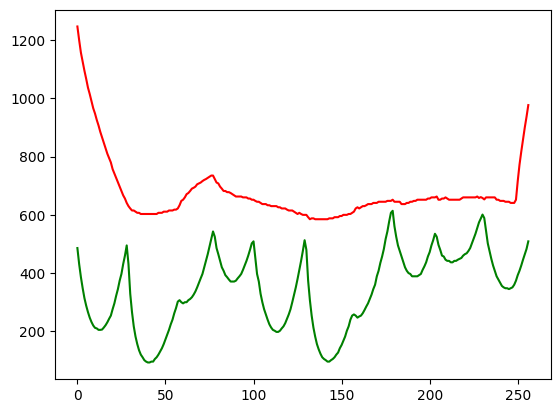

In [16]:
%cd {HOME}
import matplotlib.pyplot as plt
import numpy as np
from courtiq_utils import get_frame_xys_from_csv


# frame_to_xy = get_frame_xys_from_csv('TrackNetV3/pred_result/rally_ball.csv')

# frame = np.arange(len(frame_to_xy))
# x = [f[0] for f in frame_to_xy.values()]
# y = [f[1] for f in frame_to_xy.values()]
# y_1 = np.gradient(y)
# y_2 = np.gradient(y_1)


# plt.plot(frame, x,color="red")
# plt.plot(frame, y,color="green")
# plt.show()


In [1]:
import os
HOME = os.getcwd()
print(HOME)

/root


## Plotting player arm during shot

/root
shot happens at frame 239


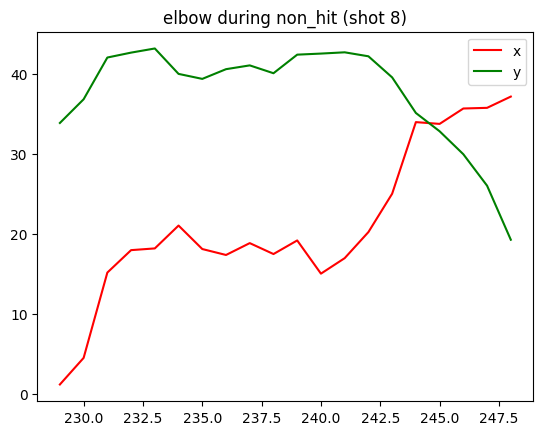

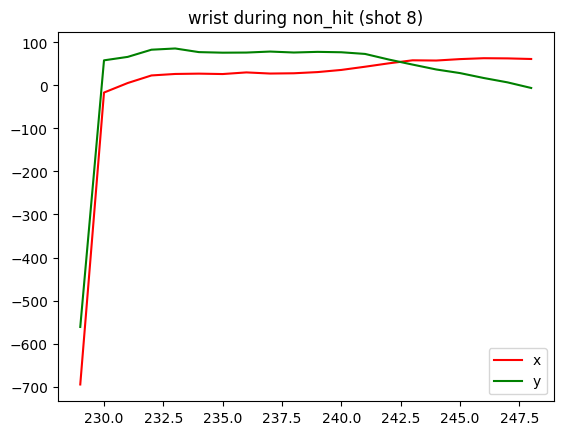

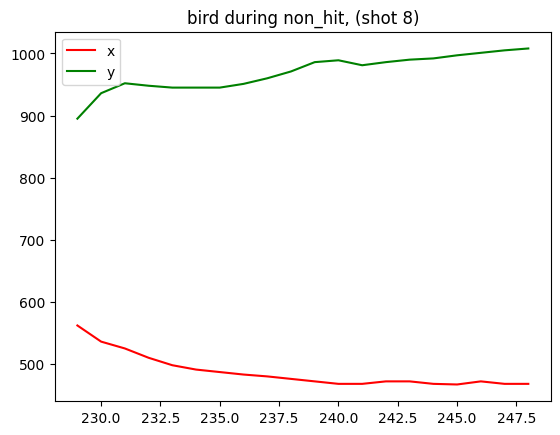

<Figure size 640x480 with 0 Axes>

In [4]:
%cd {HOME}
import supervision as sv
from courtiq_utils import plot_shot

shot_idx = 8
type_of_shot = "non_hit"
csv = "./TrackNetV3/pred_result/rally2_ball.csv"

plot_shot(shot_idx=shot_idx, csv_file=csv, type_of_shot=type_of_shot, video_num=2, save_dir=f'./output/shot_charts/{type_of_shot}')

